# Gridworld

*Andrea Mazzolini*, andrea.mazzolini.90@gmail.com.


Here we want to find the optimal strategy of a 2d grid-world problem having no information about the environment. The
**Q-learning** algorithm will be used.

## Gridworld as a Markov Decision Process

### States
The state space corresponds to the physical space of the gridworld. Therefore each state is identified by the two coordinates, and the whole space is composed of $d^2$ states:

$$
\mathcal{S} = \{ 0, 1, \ldots, d-1 \} \times \{ 0, 1, \ldots, d-1 \}
$$

### Actions
The actions of the agent are five: he can move to nearest neighbours or stay in the cell without moving:

$$
\mathcal{A} = \{ \text{up}, \text{left}, \text{down}, \text{right}, \text{stay} \} = \{ (0,1), (-1,0), (0,-1), (1,0), (0,0)\}
$$

which can be expressed also translation vectors.
Actually, these actions are not always possible in each state: the agent cannot cross boundaries. This makes actions state dependent, for example if the agent is located on the left boundary: $\mathcal{A}(0,y) = \{ \text{up}, \text{down}, \text{right}, \text{stay} \}$, or in a corner: $\mathcal{A}(d-1,d-1) = \{ \text{left}, \text{down}, \text{stay} \}$.

### Transition probabilities

The transition probabilities between states are deterministic: the next state is just the old state plus the translation action chosen by the agent:

$$
p(s_{t+1} | a_t, s_t) = \delta (s_{t+1} = a_t + s_t)
$$

### Rewards

The rewards depends only on the arrival states, $r(s_{t+1})$, and are zero for all the states with the exception of some special ones chosen to contain some resource.

## Q-learning

Q-learning is a reinforcement learning algorithm for any finite Markov decision processes (state and action space must be discrete and finite), which can converge to an optimal policy for maximizing an exponentially discounted return.
It does not require a model (hence the connotation "model-free") of the environment.
For a "model" we mean the knowledge of the transition probabilities and reward function of the MDP. Differently value iteration or dynamic programming rely on this information.

### Table for the state-action qualitites

The general idea of the algorithm is to build a table of estimates of "goodness" of each state and action pairs. This object is called Quality matrix: ${Q}(s, a)$. It can be proven that, when the algorithm converge, the Qualitiy becomes the best quality function:

$$
Q(s,a) \rightarrow Q^*(s,a) = \max_{\pi} \left[ \mathbb{E}_\pi\left[ \sum_{t=0}^\infty \gamma^t\,r_t \Big| s_0 = s, a_0 = a \right] \right]
$$

which is the best possible return starting from the state $s$ and taking the action $a$.
By assuming that $Q$ are good estimates of $Q^*$, the best policy is deterministic and, for each state $s$, consists in choosing the action that leads to the best possible return:

$$
\pi^*(s) = \delta (a - \text{argmax}_b Q(s,b))
$$

### Finding the quality matrix

The core of the algorithm is a simple online quality update. At time $t$ the learning agent is in the state $s_t$ and take the action $a_t$ (later we specify how to choose the action). As a consequence it moves to a new state $s_{t+1}$ taking the reward $r_t$. Note that $s_{t+1}$ and $r_t$ are stochastic outcomes of the MDP, that the agent can just sample (it doesn't have a model and then a prediction of what they are).
The Q-learning update rule for the Quality is:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left(r_t + \gamma \max_b Q(s_{t+1}, b) - Q(s_t, a_t)\right)
$$

$$
Q(s_t, a_t)^* = \mathbb{E} \left[ r_t + \gamma \max_b Q^*(s_{t+1}, b) \right] 
$$

where $\gamma$ is the discount factor defined in the return that one aims to maximize, and $\alpha$ is a learning rate.
Note that the Bellman equation for the quality reads $Q(s_t, a_t)^* = \mathbb{E} \left[ r_t + \gamma \max_b Q(s_{t+1}, b) \right] $, and the error appearing in the learning rule above says exactly how much I am far away from satisfying the equation with my sample. 

### Pseudocode for Q-learning

Therefore, the algorithm consists simply in starting from an initial configuration fo the Quality table, and then "play the game"
$$
s_0, a_0 \rightarrow r_0, s_1, a_1 \rightarrow r_1, s_2, a_2 \rightarrow \ldots
$$
and update the Quality as specified above after each transition.

We still have to specify how to choose actions. Here we consider an epsilon-greeedy strategy. Let us define two way of choosing the action:
- **Exploration** move, where the action is choosen uniformely at random among the possible action from the state in which the aget is.
- **Exploitation** move, where the action is taken as the one that maximize my current Qualitites, which is the best action that I can take according to my estimates of the returns, $a_t = \text{argmax}_b Q(s_t, b)$.

An epsilon-greeedy strategy says that the exploration move is chosen with probability $\epsilon$, and the exploitation one otherwise.

Putting everything together, the pseudocode for an epsilon-greedy Q-learning algorithm is the following:

 - Initialize the Q-matrix and choose the algorithm parameters $\gamma$, $\alpha$, $\epsilon$.
 - Set the agent in the starting state $s_0$.
 - For $t = 1, \ldots$ until convergence:
> - With probability $\epsilon$ choose $a_t$ at random from the possible actions, otherwise choose the action that maximizes the Qualities $a_t = \text{argmax}_b Q(s_t, b)$.
> - Play a step in the game and get the new state and the reward $s_t, a_t \rightarrow s_{t+1}, r_t$
> - Update the quality matrix using the obtained sample
> $$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left(r_t + \gamma \max_b Q(s_{t+1}, b) - Q(s_t, a_t)\right)
$$

### Episodic game and exploration scheduling

Actually one usually introduces two tricks to speed up the covergence of the quality table.

The first is to restart the game after a given number of steps (the state is forced to be $s_0$ again). Each of these runs is called episode. This is natural if there are terminal states and, at some point, the game finishes. However, it can be useful to rerestart the game when I'm interested in a particular initial condition. In this way, I force the algorithm to explore more and have better estimates around this initial condition.

A second trick is to schedule the exporation parameter $\epsilon$. Usually, I want the exploration to be large at the beginning, to have an approximate idea of all the possible qualities. L
ater I want instead to focus on the best moves to have more fine-tuned estimates of them, forgetting about the bad actions.

Rewriting the pseudocode following these two observations we have:

 - Initialize the Q-matrix and choose the algorithm parameters $\gamma$, $\alpha$, $\epsilon_0$, $T_{episode}$.
> For episodes $e = 1, \ldots$ until convergence:
> - Set the agent in the starting state $s_0$.
> - For steps in the episode $t = 1, \ldots, T_{episode}$:
>> - With probability $\epsilon_e$ choose $a_t$ at random from the possible actions, otherwise choose the action that maximizes the Qualities $a_t = \text{argmax}_b Q(s_t, b)$.
>> - Play a step in the game and get the new state and the reward $s_t, a_t \rightarrow s_{t+1}, r_t$
>> - Update the quality matrix using the obtained sample
>> $$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left(r_t + \gamma \max_b Q(s_{t+1}, b) - Q(s_t, a_t)\right)
$$
> - Decrease the exploration rate $\epsilon_e$.

## Implementation

### Environment class: the gridworld

The Gridworld class contains all the information about the environment:
- The info about the state space, the current state of the game and the initial state.
- The set of possible actions.
- The reward table: which reward the agent take in each cell (0 if none).

The methods are:
- `reset()`: the game is initialized. Here the only initialization is to put the agent in the starting cell. 
- `step(action)`: update the agent state according to the `action` passed and compute reward. Returns the state after the transition (the movement) and the reward.

In [1]:
import numpy as np
from copy import copy
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm


class Gridworld:

    def __init__(self, grid_size, init_cell, rewards, obstacles=[]):
        """
        Training environment for reinforcement learning: gridworld.
        Args:
        - grid_size, (int, int): defining the size of the 2d lattice
        - init_cell, (int, int): coordinates from 0 to size-1 from which the agent starts to play
        - rewards, list((int, int), float): list of the coordinates and values of the rewards
        - obstacles, lits((int, int)): list of the coordinates of the obstacles
        """

        # Define state space
        self.state = None  # current state of the game
        self.state_dim = grid_size
        self.init_state = init_cell
        self.obstacles = obstacles
        # Cells that are not obstacles
        self.states = [(i,j) for i in range(self.state_dim[0]) for j in range(self.state_dim[1]) if (i,j) not in self.obstacles] 

        # Define action space
        self.action_dim = (5,)  # up, right, down, left, stay
        self.action_dict = {"up": 0, "right": 1, "down": 2, "left": 3, "stay": 4}
        self.action_coords = [(0, 1), (1, 0), (0, -1), (-1, 0), (0, 0)]  # translations
        self.actions_allowed = self._build_allowed_actions(obstacles)

        # Define rewards table
        self.R = self._build_rewards(rewards)


    def reset(self):
        """Reset agent state to its initial cell""" 
        self.state = self.init_state
        return self.state


    def step(self, action):
        """Update agent state"""
        state_next = (self.state[0] + self.action_coords[action][0],
                      self.state[1] + self.action_coords[action][1])
        # Collect reward
        reward = self.R[state_next]
        # Update state
        self.state = state_next
        return state_next, reward


    def _build_allowed_actions(self, obstacles):
        actions_allowed = dict()
        Nx, Ny = self.state_dim
        for x in range(Nx):
            for y in range(Ny):
                # Actions not allowed at the boundaries
                actions_allowed[(x,y)] = [self.action_dict["stay"]] # The stay action is always allowed
                if (y > 0):  
                    actions_allowed[(x,y)].append(self.action_dict["down"])
                if (y < Ny - 1):  
                    actions_allowed[(x,y)].append(self.action_dict["up"])
                if (x > 0):  
                    actions_allowed[(x,y)].append(self.action_dict["left"])
                if (x < Nx - 1):  
                    actions_allowed[(x,y)].append(self.action_dict["right"])
                actions_allowed[(x,y)] = np.array(actions_allowed[(x,y)], dtype=int)

                # Actions not allowed because of obstacles
                for o in obstacles:
                    if (x+1,y) == o:
                        actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["right"]]
                    if (x-1,y) == o:
                        actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["left"]]
                    if (x,y+1) == o:
                        actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["up"]]
                    if (x,y-1) == o:
                        actions_allowed[(x,y)] = actions_allowed[(x,y)][actions_allowed[(x,y)] != self.action_dict["down"]]
        return actions_allowed


    def _build_rewards(self, rewards):
        R = np.zeros(self.state_dim, dtype=float)
        for rew in rewards:
            R[rew[0]] = rew[1]
        return R

    def display(self, values=np.array([]), cmap=sns.dark_palette("red", as_cmap=True), figsize=(7,6)):
        fig = plt.figure(figsize=figsize)
        obstacle_mask = np.zeros(self.state_dim, dtype=bool)
        for obs in obstacles:
            obstacle_mask[obs[0], obs[1]] = True

        if len(values)==0:
            ax = sns.heatmap(obstacle_mask.T, cmap=cm.get_cmap("Greys"), cbar=False, 
                       linewidths=0.1, linecolor='#222222')
        else:
            ax = sns.heatmap(values.T, mask=obstacle_mask.T, cmap=cmap, 
                       linewidths=0.1, linecolor='#222222', vmin=np.min(values[values != 0]))
            ax.collections[0].colorbar.set_label("Value", fontsize=14)

        ax.invert_yaxis()
        ax.set_xlabel('x', fontsize=14)
        ax.set_ylabel('y', fontsize=14)
        ax.scatter([start_cell[0]+0.5],[start_cell[1]+0.5], s=100, c='grey', label='Start')
        
        for rew in rewards:
            ax.scatter([rew[0][0]+0.5],[rew[0][1]+0.5], s=200*rew[1], c='red', label='Reward:{}'.format(rew[1]), marker='*')
        plt.tight_layout()

        return fig, ax


    def display_best_path(self, Q, start_coord, lcolor='black', values=np.array([]), cmap=sns.dark_palette("red", as_cmap=True), figsize=(7,6)):
        fig, ax = self.display(values, cmap, figsize)
        obstacle_mask = np.zeros(self.state_dim, dtype=bool)

        s, count, best_action = start_coord, 0, 0
        while best_action != 4 or count < self.state_dim[0]*self.state_dim[1]:
            count += 1
            best_action = np.argmax(Q[s[0], s[1], :])
            new_s = s[0] + self.action_coords[best_action][0], s[1] + self.action_coords[best_action][1]
            ax.plot([s[0]+0.5, new_s[0]+0.5], [s[1]+0.5, new_s[1]+0.5], c='black', lw=3)
            s = new_s

        plt.tight_layout()

        return fig, ax

### Agent class: the Q-learning algorithm

This class defines how the agent chooses the action from each state and how improve its strategy while playing.
It emplys a Q-learning algorithm with epsilon-greedy policy.
In particular:
- `get_action()` returns an action using the epsilon greedy rule.
- `train()` performs one step of the Q-learning update.

In [2]:
class QL_agent:

    def __init__(self, env, gamma, learning_rate=0.1, eps_decay=0.995):

        # Store the environment
        self.env = env

        # Agent learning parameters
        self.epsilon = 1.0  # initial exploration probability
        self.epsilon_decay = eps_decay  # epsilon decay after each episode
        self.alpha = learning_rate
        self.gamma = gamma  # reward discount factor

        # Initialize Quality matrix
        self.Q = np.zeros(env.state_dim + env.action_dim, dtype=float)


    def get_action(self):
        """
        Choose an action using an epsilon greedy policy: random with probability
        epsilon, greedy otherwise.
        """
        state = self.env.state
        actions_allowed = self.env.actions_allowed[state]
        if np.random.rand() < self.epsilon:  # explore
            return np.random.choice(actions_allowed)
        else:  # exploit
            Q_s = self.Q[state[0], state[1], actions_allowed]
            actions_greedy = actions_allowed[np.flatnonzero(Q_s == np.max(Q_s))]
            return np.random.choice(actions_greedy)


    def train(self, transition):
        """
        Q-learning update
        """
        (state, action, state_next, reward) = transition
        sa = state + (action,)
        td_error = reward + gamma * np.max(self.Q[state_next]) - self.Q[sa]
        self.Q[sa] += self.alpha * td_error

    @property
    def values(self):
        vals = np.zeros(self.env.state_dim)
        for i in range(len(self.Q)):
            for j in range(len(self.Q[0])):
                vals[i,j] = np.max(self.Q[i,j])
        return vals

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12739efb278>)

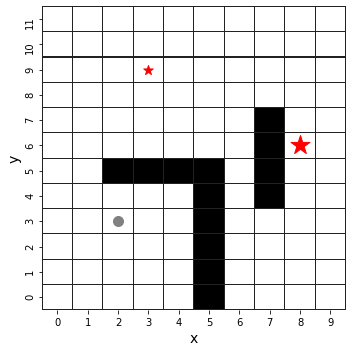

In [3]:
world_size = (10,12) # dimension of the gridworld

start_cell = (2,3)
obstacles = [(2,5), (3,5), (4,5), (5,5), (5,4), (5,3), (5,2), (5,1), (5,0),
             (7,4), (7,5), (7,6), (7,7)]
rewards = [((8,6), 2), ((3,9), 0.5)]

gridworld = Gridworld(world_size, start_cell, rewards, obstacles) # Building the world
gridworld.display(figsize=(5,5)) # And showing it

### Main learning cycle

It follows the second pseudocode written before.

In [6]:
n_episodes = 2000
n_steps_in_episode = 200 
eps_decay = 0.999 # Multiplicative decay factor for the exploration rate
gamma = 0.95
learning_rate=0.1

agent = QL_agent(gridworld, gamma, learning_rate, eps_decay)

# Iteration over all the episodes
for episode in range(n_episodes):

    state = gridworld.reset() # Setting the agent in the initial cell

    for _ in range(n_steps_in_episode):
        action = agent.get_action()  # get action
        state_next, reward = gridworld.step(action)  # evolve state by action
        agent.train((state, action, state_next, reward)) # train agent
        state = state_next  # transition to next state

    agent.epsilon = max(agent.epsilon * agent.epsilon_decay, 0.02) # Decrease the exploration
    # Show training info
    sys.stdout.write("\rEpisode: " + str(episode+1) + "/" + str(n_episodes) + " epsilon: " + str(agent.epsilon))
    sys.stdout.flush()
    

Episode: 2000/2000 epsilon: 0.13519992539749944

(<Figure size 360x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1274da17ba8>)

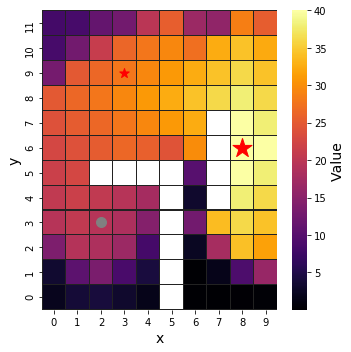

In [7]:
gridworld.display(agent.values, cmap=cm.get_cmap('inferno'), figsize=(5,5))

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1274da1cb00>)

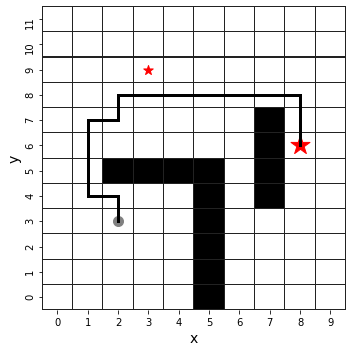

In [8]:
gridworld.display_best_path(agent.Q, start_cell, cmap=cm.get_cmap('inferno'), figsize=(5,5))